In [21]:
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessClassifier
from visualize import *
from calibration import *
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

NUM_BINS = 10
N = 1000 # takes value from 1 to 10000
NUM_CLASSES =  100
NUM_CLASSES_PLOT = 4
NUM_COL = 2
METHOD_NAME = "binary_gp"

In [2]:
# Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
#       following by softmax of output logits of this image for each class.
data = np.genfromtxt("data/cifar100_predictions_dropout.txt")[0:N,:]# 10000*101

In [3]:
p = data[:,1:]
Y_predict = np.argmax(p, axis=1)
Y_true = data[:,0]

# Fit GP to each class

In [30]:
def gp_regression(ax, x, y):
    
    # Fit GaussianProcessRegressor and LinearRegression models
    kernel = RBF(0.01, (0.05, 1))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gp.fit(x[:, np.newaxis], y-0.5)
    y_, sigma_ = gp.predict(x[:, np.newaxis], return_std=True)
    y_ += 0.5
    
    lr = LinearRegression()
    lr.fit(x[:, np.newaxis], y)  # x needs to be 2d for LinearRegression
    

    ax.plot(x, y, 'r.', markersize=12, alpha = 0.2)
    ax.plot(x, y_, 'b^', markersize=12, alpha = 0.2)
    
    x_plot = np.atleast_2d(np.linspace(0, 1, 100)).T
    y_plot, sigma = gp.predict(x_plot, return_std=True)
    y_plot += 0.5
    ax.fill(np.concatenate([x_plot, x_plot[::-1]]),
             np.concatenate([y_plot - 1.9600 * sigma,
                            (y_plot + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None')
    
    ax.plot(x, lr.predict(x[:, np.newaxis]), 'b-')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # compute ece and acc after calibration
    ece = EceEval(np.array([1-y_, y_]).T , y, num_bins = 20)
    y_predict = y_ > 0.5
    acc = (y_predict == y).mean()
    
    ax.text(0.05, 0.8, 'ECE=%.4f\nACC=%.4f'% (ece, acc), size=14, ha='left', va='center',
            bbox={'facecolor':'green', 'alpha':0.5, 'pad':4})
    
    return ax

(1000,)
(1000,)
(1000,)
(1000,)


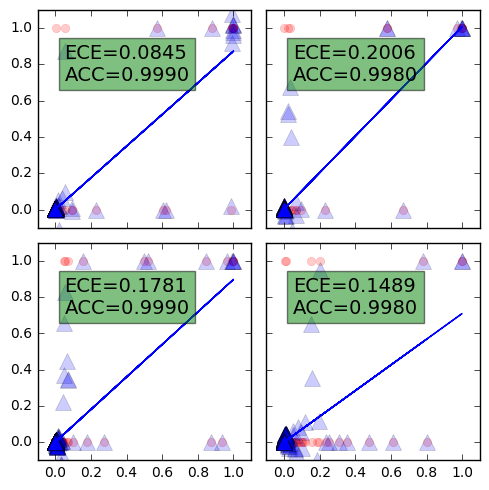

In [31]:
f, ax = plt.subplots(NUM_CLASSES_PLOT/NUM_COL, NUM_COL, sharex='col', sharey='row')
f.set_figheight(5)
f.set_figwidth(5)
for K in range(NUM_CLASSES_PLOT):
    ax[K/NUM_COL, K%NUM_COL] = gp_regression(ax[K/NUM_COL, K%NUM_COL],
                                             p[:,K],
                                             np.array((Y_true == K)) * 1)
f.tight_layout()
#f.savefig("figures/%s/reliability_per_class.png" % METHOD_NAME)
#f.savefig("figures/%s/reliability_per_class.eps" % METHOD_NAME, format='eps',dpi=1000)
#plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')